# Adversarial Examples on Food-101 Dataset

### Import Libraries

In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchinfo import summary
import pickle
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Set Configuration Variables

In [2]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
DATA_DIR = './data'
FINE_TUNE_EPOCHS = 0
BEST_MODEL_PATH = 'results/bestmodel.pth'

### Transformations and Pretrained Model

In [9]:
train_transform =  transforms.Compose([
    transforms.RandomResizedCrop(size = 224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#Test does not use augmentation, only normalization is being performed.
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(size = 224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Load datasets, first time you need to download it (may take a while). After that it should just pull the local copy
train_dataset = datasets.Food101(root=DATA_DIR, split='train', download=True, transform=train_transform)
test_dataset = datasets.Food101(root=DATA_DIR, split='test', download=True, transform=test_transform)

# Dataloaders, may need to change # of workers or batchsize to improve performance
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8)

# Pretrained model, efficient architecture
# https://paperswithcode.com/sota/fine-grained-image-classification-on-food-101
model = models.efficientnet_b2(weights='DEFAULT')

# Add one more layer to base model and then add an output layer
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, len(train_dataset.classes))
)
model.to(DEVICE)
summary(model, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
print("\n")

# Set optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()


### Train and Test functions

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(DEVICE), y.to(DEVICE)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn, save_best_model=False, best_acc=0):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()        
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.3f}%, Avg loss: {test_loss:>8f} \n")

    # Save best vesion of model at save_path
    if(100*correct > best_acc) and save_best_model:
        print("Saving New Best Model")
        best_acc = 100*correct
        save_path = BEST_MODEL_PATH
        torch.save(model.state_dict(), save_path)
    
    return best_acc

### Fine Tuning

In [13]:
best_acc = 0
for epoch in range(FINE_TUNE_EPOCHS):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    best_acc = test(test_loader, model, loss_fn, save_best_model=False, best_acc=best_acc)
print("Fine-Tuning Completed!")

Fine-Tuning Completed!


### Loading Best Performing Model

In [6]:
## Loading the model with the best accuracy after a number of fine-tuning epochs
model_path = BEST_MODEL_PATH
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
print(f"Model loaded from {model_path}")
model = model.to(DEVICE)
test(test_loader, model, loss_fn, save_best_model=False)
print("\n")

Model loaded from results/bestmodel.pth
Test Error: 
 Accuracy: 80.836%, Avg loss: 1.423222 





### Our PGD Implementation

In [5]:
def PGD(model, loss_function, data, proj_norm=2, eps=0.03, lr=0.01, steps=10, num_iter=10):

	device = next(model.parameters()).device # Ben added this - was having consistency issues

	features, labels = data
	features = features.clone().detach().to(device)
	labels = labels.clone().detach().to(device)

	adv_features = features.clone().detach().to(device)

	# Starting at a uniformly random point
	adv_features = adv_features + torch.empty_like(adv_features).uniform_(-eps, eps)
	adv_features = torch.clamp(adv_features, min=0, max=1).detach()


	#maximize loss wrt feature perturbations, for fixed network parameters
	for i in range(steps):
		adv_features.requires_grad = True

		#model prediction
		pred = model(adv_features)

		#error calculation
		error = loss_function(pred, labels)

		#gradient descend
		grad = torch.autograd.grad(error, adv_features, retain_graph=False, create_graph=False)[0] #grad:(1, 64, 3, 224, 224), where the first coordinate if the batch number?
		#grad_norm = torch.norm(grad, p=proj_norm, dim=[1,2,3]) #normalize the gradient according to paper https://arxiv.org/pdf/1706.06083

		adv_features = adv_features.detach() + lr * grad.sign() #grad

		diff = torch.clamp(adv_features - features, min=-eps, max=eps)
		adv_features = torch.clamp(features + diff, min=0, max=1).detach()

	return adv_features

### Implementations of FGSM and Iterated FGSM. 

In [6]:
def ifgsm(model, loss_fn, data, eps=0.03, alpha=0.01, num_iter=10):  
    features, labels = data
    features = features.clone().detach().to(DEVICE)
    features.requires_grad = True  
    labels = labels.clone().detach().to(DEVICE)
    model.eval()

    perturbed_data = features.clone() 

    for i in range(num_iter):  # Iterate for num_iter times
        output = model(perturbed_data)
        loss = loss_fn(output, labels)
        model.zero_grad()
        loss.backward(retain_graph=True)
        sign_data_grad = features.grad.data.sign()

        perturbed_data += alpha * sign_data_grad  
        perturbed_data = torch.clamp(perturbed_data, features - (eps/num_iter), features + (eps/num_iter))  
        perturbed_data = torch.clamp(perturbed_data, 0, 1)

    return perturbed_data

    

### Function to Test Adversarial Attacks

Checks how our model performs on different adversarial attacks

In [7]:
def test_with_adv(dataloader, model, loss_fn, attack, eps=0.0, num_iter=1,
                  save_best_model=False, best_acc=0, model_path=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    date_and_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    pickle_file_path = f"results/experiments/{attack.__name__}-{num_iter}-{date_and_time}.pkl"

    for X, y in dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        if attack == "GN":
            atk = attack(model, std=np.sqrt(eps))
            adv_examples = atk(X, y)
        else:
            adv_examples = attack(model, loss_fn, (X, y), eps=eps, num_iter=num_iter) # (Ben) last parameter is for iterated FGSM.
        with open(pickle_file_path, 'wb+') as f:
            pickle.dump(adv_examples, f)

        pred = model(adv_examples)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>.3f}%, Avg loss: {test_loss:>8f} \n")

    with open(pickle_file_path, 'wb') as f:
        pickle.dump((correct, test_loss), f)

    # Save best vesion of model at save_path
    if(100*correct > best_acc) and save_best_model:
        print("Saving New Best Model")
        best_acc = 100*correct
        if model_path:
            save_path = model_path
        else: 
            save_path = BEST_MODEL_PATH 
        torch.save(model.state_dict(), save_path)
    

    return correct, test_loss


#### Testing Iterated FGSM for different number of iterations `num_iter`

In [33]:
## Our FGSM Implementation
print(f"--- Attack: Our FGSM Implementation ----")
iterated_fgsm_data = dict()
for i in range(1, 11):
    correct, loss = test_with_adv(test_loader, model, loss_fn, ifgsm, eps=eps, num_iter=i)
    iterated_fgsm_data[i] = [(correct, loss)]

--- Attack: Our FGSM Implementation ----
Test Error: 
 Accuracy: 15.240%, Avg loss: 8.742095 

Test Error: 
 Accuracy: 6.190%, Avg loss: 14.003637 

Test Error: 
 Accuracy: 8.178%, Avg loss: 12.394408 

Test Error: 
 Accuracy: 10.115%, Avg loss: 11.222253 

Test Error: 
 Accuracy: 11.505%, Avg loss: 10.499423 

Test Error: 
 Accuracy: 12.578%, Avg loss: 10.024014 

Test Error: 
 Accuracy: 13.465%, Avg loss: 9.690408 

Test Error: 
 Accuracy: 14.147%, Avg loss: 9.444383 

Test Error: 
 Accuracy: 14.665%, Avg loss: 9.260505 

Test Error: 
 Accuracy: 15.208%, Avg loss: 9.110864 



#### Testing PGD for different number of iterations `num_iter`

In [13]:
## Our PGD Implementation
print(f"--- Attack: Our PGD Implementation ----")
eps = 0.01
for i in range(1, 11):
    correct, loss = test_with_adv(test_loader, model, loss_fn, PGD, eps=eps, num_iter=i)

--- Attack: Our PGD Implementation ----
Test Error: 
 Accuracy: 1.164%, Avg loss: 24.898600 

Test Error: 
 Accuracy: 1.156%, Avg loss: 24.896214 

Test Error: 
 Accuracy: 1.149%, Avg loss: 24.899586 

Test Error: 
 Accuracy: 1.168%, Avg loss: 24.902878 

Test Error: 
 Accuracy: 1.172%, Avg loss: 24.900782 

Test Error: 
 Accuracy: 1.164%, Avg loss: 24.898994 

Test Error: 
 Accuracy: 1.164%, Avg loss: 24.902583 

Test Error: 
 Accuracy: 1.160%, Avg loss: 24.904563 

Test Error: 
 Accuracy: 1.152%, Avg loss: 24.906192 

Test Error: 
 Accuracy: 1.164%, Avg loss: 24.913185 



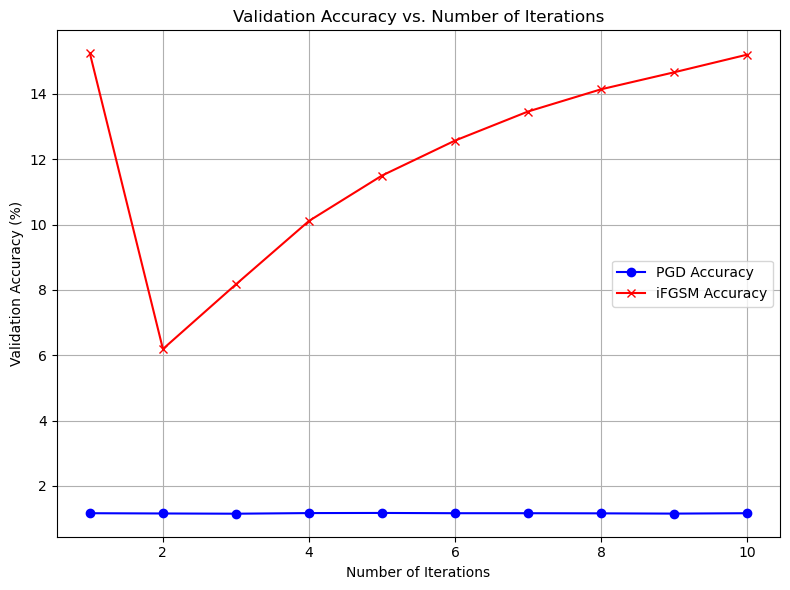

In [21]:
# Data for PGD
pgd_data = {
    'num_iter': list(range(1, 11)),
    'accuracy': [1.164, 1.156, 1.149, 1.168, 1.172, 1.164, 1.164, 1.160, 1.152, 1.164]
}

# Data for iFGSM
ifgsm_data = {
    'num_iter': list(range(1, 11)),
    'accuracy': [15.24, 6.19, 8.17, 10.11, 11.50, 12.57, 13.46, 14.14, 14.66, 15.20]
}

# Create a new figure
plt.figure(figsize=(8, 6))

# Plot PGD accuracy vs num_iter
plt.plot(pgd_data['num_iter'], pgd_data['accuracy'], label='PGD Accuracy', color='b', linestyle='-', marker='o')

# Plot iFGSM accuracy vs num_iter
plt.plot(ifgsm_data['num_iter'], ifgsm_data['accuracy'], label='iFGSM Accuracy', color='r', linestyle='-', marker='x')

# Set title and labels
plt.title("Validation Accuracy vs. Number of Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Validation Accuracy (%)")
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


### Testing PGD and FGSM with different `eps`
`num_iter` == 1

In [18]:
eps_values = [0.0001, 0.001, 0.01, 0.1, 1]
# List to hold all results
results = []

for attack in [PGD, ifgsm]:
    correct_values, loss_values = [], []
    print(f"--- Attack: {attack.__name__} ----")
    for eps in eps_values:
        ## Reload model to avoid learned features
        model_path = BEST_MODEL_PATH
        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict)
        print(f"Model loaded from {model_path}")
        model = model.to(DEVICE)

        correct, loss = test_with_adv(test_loader, model, loss_fn, attack, eps=eps, num_iter=1)

        correct_values.append(correct)
        loss_values.append(loss)

        # Add the results to the list as a dictionary
        results.append({
            'attack': attack.__name__,
            'epsilon': eps,
            'correct': correct,
            'loss': loss
        })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_df.to_csv("results/experiments/accuracy_vs_eps.csv", index=False)

print("Results saved to accuracy_vs_eps.csv")

--- Attack: general_PGD ----
Model loaded from results/bestmodel.pth
Test Error: 
 Accuracy: 19.659%, Avg loss: 7.972062 

Model loaded from results/bestmodel.pth
Test Error: 
 Accuracy: 15.200%, Avg loss: 9.110861 

Model loaded from results/bestmodel.pth
Test Error: 
 Accuracy: 1.168%, Avg loss: 24.906147 

Model loaded from results/bestmodel.pth
Test Error: 
 Accuracy: 0.004%, Avg loss: 140.368373 

Model loaded from results/bestmodel.pth
Test Error: 
 Accuracy: 0.000%, Avg loss: 158.557669 

--- Attack: ifgsm ----
Model loaded from results/bestmodel.pth
Test Error: 
 Accuracy: 20.087%, Avg loss: 7.861527 

Model loaded from results/bestmodel.pth
Test Error: 
 Accuracy: 19.640%, Avg loss: 7.936327 

Model loaded from results/bestmodel.pth
Test Error: 
 Accuracy: 15.244%, Avg loss: 8.742904 

Model loaded from results/bestmodel.pth
Test Error: 
 Accuracy: 15.244%, Avg loss: 8.742904 

Model loaded from results/bestmodel.pth
Test Error: 
 Accuracy: 15.244%, Avg loss: 8.742904 

Result

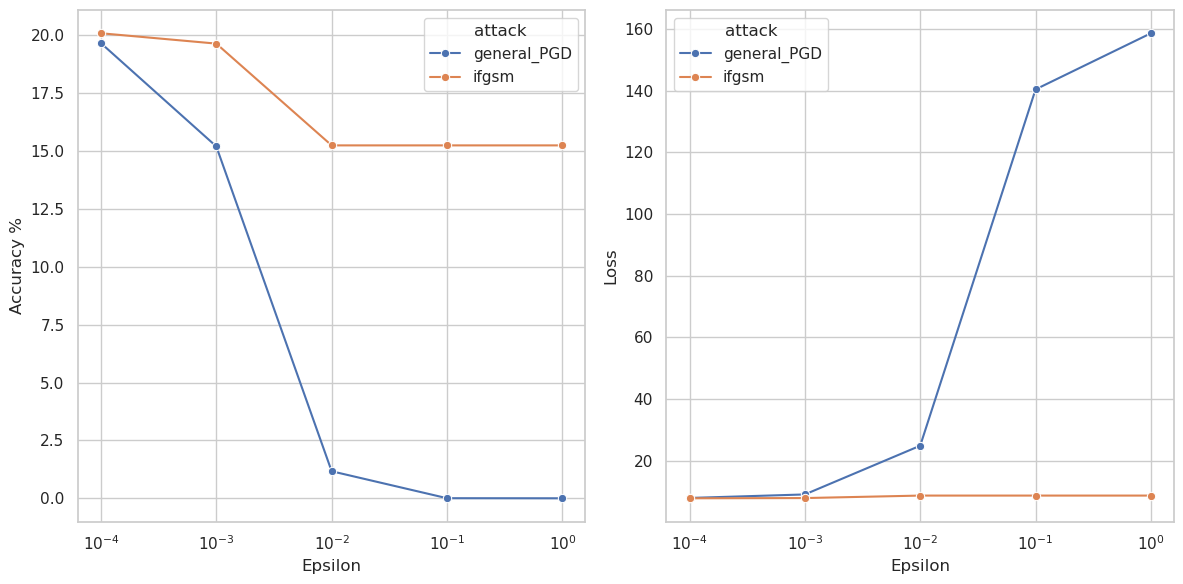

In [23]:
# Read data from CSV into a DataFrame
df = pd.read_csv("results/experiments/accuracy_vs_eps.csv")
df["correct"] = df["correct"] * 100

# Set the style for the plot
sns.set(style="whitegrid")

# Create subplots for correct and loss values
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# Plot correct values with a logarithmic x-axis
sns.lineplot(data=df, x="epsilon", y="correct", hue="attack", marker='o', ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_xlabel("Epsilon")
axes[0].set_ylabel("Accuracy %")

# Plot loss values with a logarithmic x-axis
sns.lineplot(data=df, x="epsilon", y="loss", hue="attack", marker='o', ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_xlabel("Epsilon")
axes[1].set_ylabel("Loss")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## Adversarial Training

In [7]:
def train_with_adv(dataloader, model, loss_fn, optimizer, attack, eps=0.0, num_iter=1):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(DEVICE), y.to(DEVICE)

        # Adversarial perturbation using PGD
        adversary = attack(model, loss_fn, (X, y), eps=eps, num_iter=num_iter)

        # Compute prediction error
        pred = model(adversary)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [27]:
## Loading the model with the best accuracy after a number of fine-tuning epochs
ADVERSARIAL_TRAINING_EPOCHS = 1
model_path = BEST_MODEL_PATH

for attack in [PGD, ifgsm]:
    print(f"--- Attack: {attack.__name__} ---")
    # Dataloaders, may need to change # of workers or batchsize to improve performance
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    print(f"Model loaded from {model_path}")
    model = model.to(DEVICE)
    test(test_loader, model, loss_fn, save_best_model=False) # Should be ~80 accuracy%

    # Set optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    # attack = PGD # try with ifgsm as well

    epoch_results = []
    best_acc = 0
    eps = 0.01
    num_iter = 1
    for epoch in range(ADVERSARIAL_TRAINING_EPOCHS):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_with_adv(train_loader, model, loss_fn, optimizer, attack, eps=eps, num_iter=num_iter)
        best_acc, loss = test_with_adv(test_loader, model, loss_fn, attack, eps=eps, num_iter=num_iter, 
                    save_best_model=True, best_acc=best_acc, model_path=f"results/{attack.__name__}.pth")
        
        # Save results for this epoch
        epoch_results.append({
            "epoch": epoch + 1,  # Epoch is 1-indexed
            "best_acc": best_acc,
            "loss": loss
        })

    # Create a DataFrame and save it to a CSV file
    df = pd.DataFrame(epoch_results)
    df.to_csv(f"results/experiments/adversarial_training_{attack.__name__}.csv", index=False)

    print("Results for each epoch saved to epoch_results.csv")

Model loaded from results/bestmodel.pth
Test Error: 
 Accuracy: 80.840%, Avg loss: 1.422983 

Epoch 1
-------------------------------
loss: 6.531837  [   64/75750]
loss: 3.156193  [ 6464/75750]
loss: 2.396735  [12864/75750]
loss: 1.913712  [19264/75750]
loss: 1.932488  [25664/75750]
loss: 2.376234  [32064/75750]
loss: 2.022436  [38464/75750]
loss: 2.090417  [44864/75750]
loss: 2.247800  [51264/75750]
loss: 1.992289  [57664/75750]
loss: 1.832050  [64064/75750]
loss: 1.413402  [70464/75750]
Test Error: 
 Accuracy: 52.487%, Avg loss: 2.226898 

Saving New Best Model
Results for each epoch saved to epoch_results.csv


#### Adversarial Training Results after 10 epochs
After running both PGD and FGSM for 10 epochs, the models with the best validation accuracy have been saved at `results/experiments/PGD.pth` and `results/experiments/ifgsm.pth` respectively. Configuration: `eps=0.01, num_iter=1`.

In [10]:
eps = 0.01
num_iter = 1
for attack in [PGD, ifgsm]:
    print(f"--- Attack: {attack.__name__} ---")
    model_path = f"results/{attack.__name__}.pth"
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    print(f"Model loaded from {model_path}")
    model = model.to(DEVICE)

    correct, loss = test_with_adv(test_loader, model, loss_fn, attack, eps=eps, num_iter=num_iter)

--- Attack: PGD ---
Model loaded from results/PGD.pth
Test Error: 
 Accuracy: 49.002%, Avg loss: 2.835241 

--- Attack: ifgsm ---
Model loaded from results/ifgsm.pth
Test Error: 
 Accuracy: 57.592%, Avg loss: 2.555679 



#### Plot of accuracy over time for adversarial Training

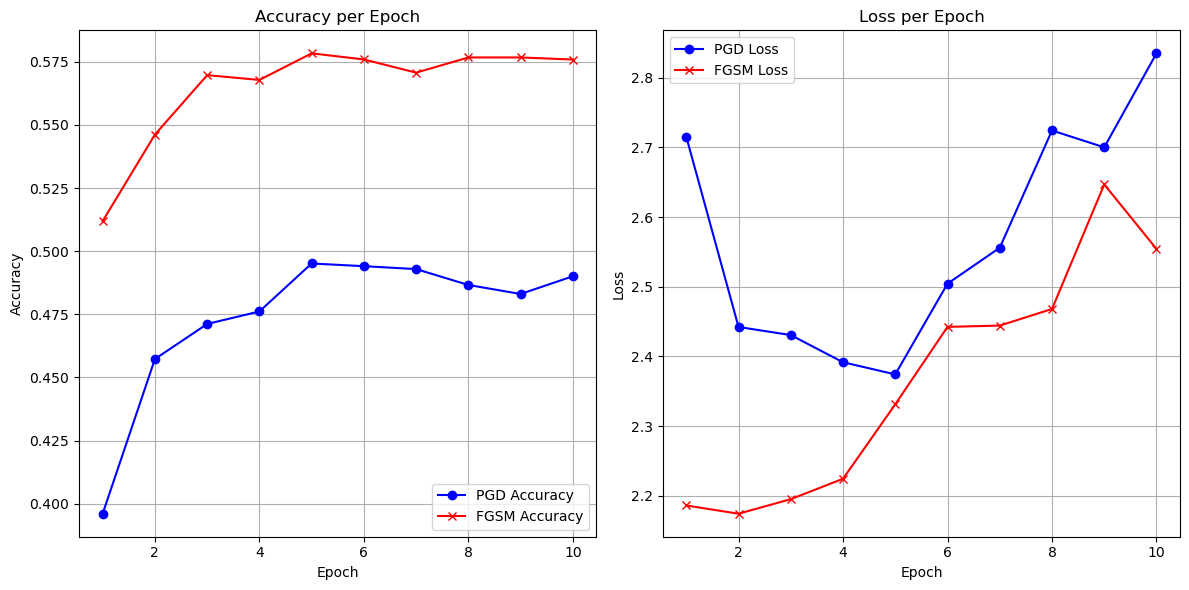

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the two files
file1 = "results/experiments/adversarial_training_PGD.csv"
file2 = "results/experiments/adversarial_training_ifgsm.csv"

data1 = pd.read_csv(file1)
data2 = pd.read_csv(file2)

# Create a new figure
plt.figure(figsize=(12, 6))

# Plot accuracy for both files
plt.subplot(1, 2, 1)
plt.plot(data1['epoch'], data1['best_acc'], label='PGD Accuracy', color='b', linestyle='-', marker='o')
plt.plot(data2['epoch'], data2['best_acc'], label='FGSM Accuracy', color='r', linestyle='-', marker='x')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot loss for both files
plt.subplot(1, 2, 2)
plt.plot(data1['epoch'], data1['loss'], label='PGD Loss', color='b', linestyle='-', marker='o')
plt.plot(data2['epoch'], data2['loss'], label='FGSM Loss', color='r', linestyle='-', marker='x')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


#### Test adversarially trained model on clean images

In [11]:
eps = 0.01
num_iter = 1
for attack in [PGD, ifgsm]:
    print(f"--- Attack: {attack.__name__} ---")
    model_path = f"results/{attack.__name__}.pth"
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    print(f"Model loaded from {model_path}")
    model = model.to(DEVICE)

    test(test_loader, model, loss_fn, save_best_model=False)

--- Attack: PGD ---
Model loaded from results/PGD.pth
Test Error: 
 Accuracy: 0.990%, Avg loss: 836.417841 

--- Attack: ifgsm ---
Model loaded from results/ifgsm.pth
Test Error: 
 Accuracy: 79.109%, Avg loss: 1.372159 



### Further Fine-Tuning on PGD

In [14]:
model_path = f"results/PGD.pth"
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
print(f"Model loaded from {model_path}")
model = model.to(DEVICE)
best_acc = 0
for epoch in range(2):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    best_acc = test(test_loader, model, loss_fn, save_best_model=False, best_acc=best_acc)

Model loaded from results/PGD.pth
Epoch 1
-------------------------------
loss: 1.372015  [   16/75750]
loss: 0.260547  [ 1616/75750]
loss: 1.314021  [ 3216/75750]
loss: 0.184096  [ 4816/75750]
loss: 0.077387  [ 6416/75750]
loss: 0.129688  [ 8016/75750]
loss: 0.226731  [ 9616/75750]
loss: 0.274313  [11216/75750]
loss: 0.621605  [12816/75750]
loss: 0.513488  [14416/75750]
loss: 0.154873  [16016/75750]
loss: 0.144958  [17616/75750]
loss: 0.511987  [19216/75750]
loss: 0.329195  [20816/75750]
loss: 0.263977  [22416/75750]
loss: 0.121059  [24016/75750]
loss: 0.170975  [25616/75750]
loss: 0.053023  [27216/75750]
loss: 0.504167  [28816/75750]
loss: 0.092029  [30416/75750]
loss: 0.926561  [32016/75750]
loss: 0.188671  [33616/75750]
loss: 0.096339  [35216/75750]
loss: 0.123045  [36816/75750]
loss: 0.534604  [38416/75750]
loss: 0.567794  [40016/75750]
loss: 0.352312  [41616/75750]
loss: 0.225471  [43216/75750]
loss: 0.428253  [44816/75750]
loss: 0.538427  [46416/75750]
loss: 0.145940  [48016/757

In [16]:
eps = 0.01
num_iter = 1
for attack in [PGD]:
    print(f"--- Attack: {attack.__name__} ---")
    correct, loss = test_with_adv(test_loader, model, loss_fn, attack, eps=eps, num_iter=num_iter)

--- Attack: PGD ---
Test Error: 
 Accuracy: 3.933%, Avg loss: 13.389145 



**Note** : While, the performance of the model is now better for both clean and adversarial images, we can see that there is a tradeoff on the accuracy of the PGD model between the clean and the adversarial images. Specifically, it seems that when the model learns to accurately classify adversarial images, it loses its ability to classify clean ones, and vice-versa. To solve this issue, we need to incorporate both clean and adversarial images on the training loop, which will increase the time it takes for an epoch to complete.